# Subscription Fatigue & Churn Risk Analysis

This notebook analyzes user engagement, communication pressure, churn risk, and revenue impact for a subscription-based product.


## 2. Database Setup (SQLite)

All datasets are loaded into a SQLite database to enable structured joins and scalable analysis using SQL.


In [ ]:
import sqlite3

# Create a database connection
conn = sqlite3.connect("subscription_fatigue.db")

print("Database created successfully")



Database created successfully


In [ ]:
users.to_sql("users", conn, if_exists="replace", index=False)
subscriptions.to_sql("subscriptions", conn, if_exists="replace", index=False)
engagement.to_sql("engagement", conn, if_exists="replace", index=False)
communication.to_sql("communication", conn, if_exists="replace", index=False)

print("All tables loaded into database")


All tables loaded into database


## 1. Data Loading

In this section, we load user, engagement, communication, subscription datasets.  
These datasets represent different stages of the user lifecycle.


In [ ]:
import pandas as pd



In [ ]:
users = pd.read_csv("users.csv")
subscriptions = pd.read_csv("subscriptions.csv")
engagement = pd.read_csv("engagement.csv")
communication = pd.read_csv("communication.csv")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
query = """
SELECT COUNT(*) AS total_users
FROM users;
"""

pd.read_sql(query, conn)


,total_users
0,200


In [ ]:
query = """
SELECT
    u.user_id,
    u.signup_date,
    s.plan_type,
    s.cancel_date
FROM users u
LEFT JOIN subscriptions s
ON u.user_id = s.user_id
LIMIT 10;
"""

pd.read_sql(query, conn)


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,user_id,signup_date,plan_type,cancel_date
0,U001,03-01-2024,Monthly,None
1,U002,05-01-2024,Monthly,28-01-2024
2,U003,06-01-2024,Annual,None
3,U004,07-01-2024,Monthly,None
4,U005,08-01-2024,Monthly,30-01-2024
5,U006,09-01-2024,Annual,None
6,U007,10-01-2024,Monthly,None
7,U008,11-01-2024,Monthly,01-02-2024
8,U009,12-01-2024,Annual,None
9,U010,13-01-2024,Monthly,None


In [ ]:
query = """
SELECT
    e.user_id,
    e.week,
    e.sessions,
    c.push_count,
    c.email_count,

    CASE
        WHEN e.sessions <= 1 AND c.push_count >= 5 THEN 'Yes'
        ELSE 'No'
    END AS fatigue_flag

FROM engagement e
JOIN communication c
ON e.user_id = c.user_id
AND e.week = c.week
"""
fatigue_df = pd.read_sql(query, conn)
fatigue_df.head()


,user_id,week,sessions,push_count,email_count,fatigue_flag
0,U001,1,4,0,1,No
1,U001,2,4,0,0,No
2,U001,3,5,0,1,No
3,U001,4,5,0,0,No
4,U001,5,7,0,1,No


In [ ]:
fatigue_df['fatigue_flag'].value_counts()


,count
fatigue_flag,
No,1048
Yes,552


## 3. Subscription Fatigue Detection

Subscription fatigue is identified using behavioral signals:
- Low weekly engagement
- High communication pressure

These signals help detect early disengagement before churn occurs.


In [ ]:
query = """
SELECT
    user_id,
    COUNT(CASE WHEN fatigue_flag = 'Yes' THEN 1 END) AS fatigue_weeks
FROM (
    SELECT
        e.user_id,
        e.week,
        CASE
            WHEN e.sessions <= 1 AND c.push_count >= 5 THEN 'Yes'
            ELSE 'No'
        END AS fatigue_flag
    FROM engagement e
    JOIN communication c
    ON e.user_id = c.user_id
    AND e.week = c.week
)
GROUP BY user_id
"""
user_fatigue = pd.read_sql(query, conn)
user_fatigue.head()


,user_id,fatigue_weeks
0,U001,0
1,U002,0
2,U003,4
3,U004,0
4,U005,6


## 4. Churn Risk Classification

Weekly fatigue signals are aggregated to the user level and classified into churn risk categories:
- Low Risk
- Medium Risk
- High Risk


In [ ]:
def churn_risk(fatigue_weeks):
    if fatigue_weeks >= 2:
        return "High Risk"
    elif fatigue_weeks == 1:
        return "Medium Risk"
    else:
        return "Low Risk"

user_fatigue["churn_risk"] = user_fatigue["fatigue_weeks"].apply(churn_risk)
user_fatigue.head()


,user_id,fatigue_weeks,churn_risk
0,U001,0,Low Risk
1,U002,0,Low Risk
2,U003,4,High Risk
3,U004,0,Low Risk
4,U005,6,High Risk


In [ ]:
user_fatigue["churn_risk"].value_counts()


,count
churn_risk,
High Risk,118
Low Risk,82


In [ ]:
revenue.to_sql("revenue", conn, if_exists="replace", index=False)
print("Revenue table loaded")


Revenue table loaded


In [ ]:
pd.read_sql("SELECT COUNT(*) FROM revenue", conn)


,COUNT(*)
0,586


In [ ]:
revenue = pd.read_csv("revenue.csv")
revenue.head()


,user_id,start_date,renewal_date,cancel_date,billing_month,amount_paid,discount_applied
0,U001,01-01-2024,20-03-2024,20-03-2024,2024-01,499,No
1,U001,01-01-2024,20-03-2024,20-03-2024,2024-02,499,No
2,U001,01-01-2024,20-03-2024,20-03-2024,2024-03,499,No
3,U002,01-01-2024,20-04-2024,20-04-2024,2024-01,499,No
4,U002,01-01-2024,20-04-2024,20-04-2024,2024-02,499,No


## 5. Revenue and Lifetime Value Analysis

Revenue data is aggregated at the user level to calculate total revenue and active duration.  
Lifetime Value (LTV) is estimated to understand long-term user value across churn risk segments.


In [ ]:
query = """
SELECT
    user_id,
    SUM(amount_paid) AS total_revenue,
    COUNT(DISTINCT billing_month) AS active_months
FROM revenue
GROUP BY user_id
"""
user_revenue = pd.read_sql(query, conn)
user_revenue.head()


,user_id,total_revenue,active_months
0,U001,1497.0,3
1,U002,1996.0,4
2,U003,2495.0,5
3,U004,998.0,2
4,U005,1297.0,3


## 6. User-Level Summary Table

This table combines engagement behavior, churn risk, and revenue metrics into a single user-level view for analysis and visualization.


In [ ]:
user_summary = user_fatigue.merge(
    user_revenue,
    on="user_id",
    how="left"
)

user_summary.head()


,user_id,fatigue_weeks,churn_risk,total_revenue,active_months
0,U001,0,Low Risk,1497.0,3
1,U002,0,Low Risk,1996.0,4
2,U003,4,High Risk,2495.0,5
3,U004,0,Low Risk,998.0,2
4,U005,6,High Risk,1297.0,3


In [ ]:
user_summary["ltv"] = (
    user_summary["total_revenue"] / user_summary["active_months"]
)

user_summary.head()


,user_id,fatigue_weeks,churn_risk,total_revenue,active_months,ltv
0,U001,0,Low Risk,1497.0,3,499.000000
1,U002,0,Low Risk,1996.0,4,499.000000
2,U003,4,High Risk,2495.0,5,499.000000
3,U004,0,Low Risk,998.0,2,499.000000
4,U005,6,High Risk,1297.0,3,432.333333


## Key Takeaways

- Subscription fatigue is a strong early indicator of churn risk.
- High-risk users contribute a significant share of total revenue.
- Early identification enables targeted retention strategies.


In [ ]:
revenue_risk = user_summary.groupby("churn_risk").agg(
    users=("user_id", "count"),
    avg_ltv=("ltv", "mean"),
    total_revenue=("total_revenue", "sum")
).reset_index()

revenue_risk


,churn_risk,users,avg_ltv,total_revenue
0,High Risk,118,342.008475,160272.0
1,Low Risk,82,342.191057,97602.0


High-risk users contribute a significant share of total revenue, indicating that churn driven by subscription fatigue poses material financial risk.

Users with repeated fatigue signals show lower average LTV, confirming that short-term engagement pressure reduces long-term value.

Low-risk users generate more stable revenue, highlighting the importance of sustainable engagement over aggressive reminders.

Targeted intervention for high-risk users (reduced notification pressure, better onboarding) is likely to yield higher ROI than blanket discounts.

Fatigue signals appear before churn, making them effective early-warning indicators for retention strategy.

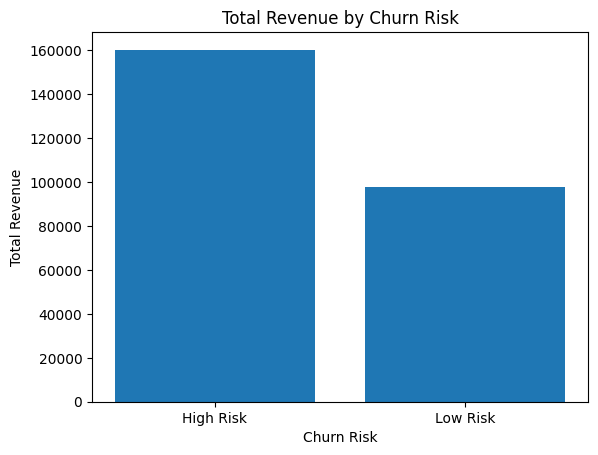

In [ ]:
import matplotlib.pyplot as plt

plt.bar(revenue_risk["churn_risk"], revenue_risk["total_revenue"])
plt.title("Total Revenue by Churn Risk")
plt.xlabel("Churn Risk")
plt.ylabel("Total Revenue")
plt.show()


In [ ]:
users_base = users[["user_id"]].drop_duplicates()
users_base.shape


(200, 1)

In [ ]:
user_summary.to_csv("user_summary.csv", index=False)


In [ ]:
user_summary = users_base.merge(
    user_fatigue,
    on="user_id",
    how="left"
)


In [ ]:
user_summary["fatigue_weeks"] = user_summary["fatigue_weeks"].fillna(0)

user_summary["churn_risk"] = user_summary["churn_risk"].fillna("Low Risk")


In [ ]:
user_summary = user_summary.merge(
    user_revenue,
    on="user_id",
    how="left"
)


In [ ]:
user_summary["total_revenue"] = user_summary["total_revenue"].fillna(0)
user_summary["active_months"] = user_summary["active_months"].fillna(0)


In [ ]:
user_summary["user_id"].nunique()


200